Langkah 1 — Muat Data
Pilihan A (pakai file split dari Pertemuan 4):

In [2]:
import pandas as pd

X_train = pd.read_csv("../P4/X_train.csv")
X_val   = pd.read_csv("../P4/X_val.csv")
X_test  = pd.read_csv("../P4/X_test.csv")
y_train = pd.read_csv("../P4/y_train.csv").squeeze("columns")
y_val   = pd.read_csv("../P4/y_val.csv").squeeze("columns")
y_test  = pd.read_csv("../P4/y_test.csv").squeeze("columns")

print(X_train.shape, X_val.shape, X_test.shape)

(6, 5) (2, 5) (2, 5)


Langkah 2 — Baseline Model & Pipeline
Bangun baseline terstandar menggunakan Logistic Regression + pipeline preprocessing.

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn. impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

num_cols = X_train.select_dtypes(include="number").columns

pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                    ("sc", StandardScaler())]), num_cols),
], remainder="drop")

logreg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
pipe_lr = Pipeline([("pre", pre),("clf", logreg)])

pipe_lr.fit(X_train, y_train)
y_val_pred = pipe_lr.predict(X_val)
print("Baseline (LogReg) F1(val):", f1_score(y_val, y_val_pred, average="macro"))
print(classification_report(y_val, y_val_pred, digits=3))

Baseline (LogReg) F1(val): 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         1

    accuracy                          1.000         2
   macro avg      1.000     1.000     1.000         2
weighted avg      1.000     1.000     1.000         2



Langkah 3 — Model Alternatif (Random Forest)

In [4]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300, max_features="sqrt", class_weight="balanced", random_state=42
    )
pipe_rf = Pipeline([("pre",pre), ("clf", rf)])

pipe_rf.fit(X_train, y_train)
y_val_rf = pipe_rf.predict(X_val)
print("RandomForest F1(val):", f1_score(y_val, y_val_rf, average="macro"))

RandomForest F1(val): 1.0


Langkah 4 — Validasi Silang & Tuning Ringkas

In [5]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
param = {
    "clf__max_depth": [None, 12, 20, 30],
    "clf__min_samples_split": [2, 5, 10]
}
gs = GridSearchCV(pipe_rf, param_grid=param, cv=skf,
                  scoring="f1_macro", n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print ("Best params:", gs.best_params_)
print ("Best CV F1:", gs.best_score_)

best_rf = gs.best_estimator_
y_val_best = best_rf.predict(X_val)
print("Best RF F1(val):", f1_score(y_val, y_val_best, average="macro"))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2}
Best CV F1: 1.0
Best RF F1(val): 1.0


Langkah 5 — Evaluasi Akhir (Test Set)

F1(test): 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         1

    accuracy                          1.000         2
   macro avg      1.000     1.000     1.000         2
weighted avg      1.000     1.000     1.000         2

Confusion matrix (test):
[[1 0]
 [0 1]]
ROC-AUC(test): 1.0


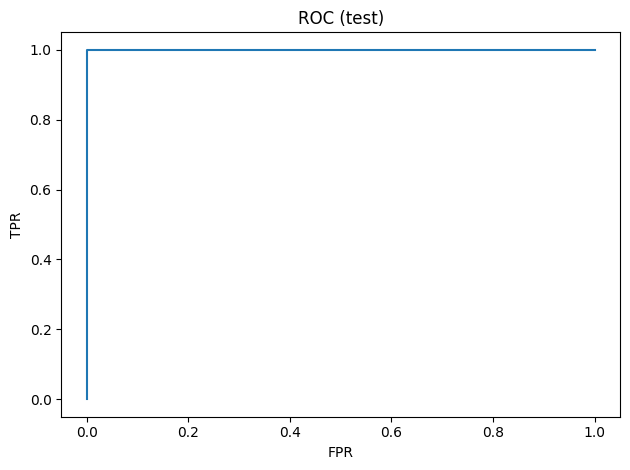

In [6]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

final_model = best_rf  # atau pipe_lr jika baseline lebih baik
y_test_pred = final_model.predict(X_test)

print("F1(test):", f1_score(y_test, y_test_pred, average="macro"))
print(classification_report(y_test, y_test_pred, digits=3))
print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_test_pred))

# ROC-AUC (jika ada predict_proba)
if hasattr(final_model, "predict_proba"):
    y_test_proba = final_model.predict_proba(X_test)[:,1]
    try:
        print("ROC-AUC(test):", roc_auc_score(y_test, y_test_proba))
    except:
        pass
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    plt.figure(); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (test)")
    plt.tight_layout(); plt.savefig("roc_test.png", dpi=120)

In [7]:
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())


Lulus
1    3
0    3
Name: count, dtype: int64
Lulus
0    1
1    1
Name: count, dtype: int64
Lulus
0    1
1    1
Name: count, dtype: int64


Langkah 6 (Opsional) — Simpan Model

In [8]:
import joblib
joblib.dump(final_model, "model.pkl")
print("Model tersimpan ke model.pkl")

Model tersimpan ke model.pkl


Langkah 7 (Opsional) — Endpoint Inference (Flask)

In [9]:
from flask import Flask, request, jsonify
import joblib, pandas as pd

app = Flask(__name__)
MODEL = joblib.load("model.pkl")

@app.route("/predict", methods=["POST"])
def predict():
    data = request.get_json(force=True)  # dict fitur
    X = pd.DataFrame([data])
    yhat = MODEL.predict(X)[0]
    proba = None
    if hasattr(MODEL, "predict_proba"):
        proba = float(MODEL.predict_proba(X)[:,1][0])
    return jsonify({"prediction": int(yhat), "proba": proba})

if __name__ == "__main__":
    app.run(port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [23/Oct/2025 01:25:53] "POST /predict HTTP/1.1" 400 -
127.0.0.1 - - [23/Oct/2025 01:25:57] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [23/Oct/2025 01:27:38] "POST /predict HTTP/1.1" 400 -
127.0.0.1 - - [23/Oct/2025 01:28:43] "POST /predict HTTP/1.1" 200 -


tes menggunakan stratifiedKfold

Distribusi kelas:
Lulus
1    5
0    5
Name: count, dtype: int64

Jumlah fold (n_splits): 5



F1_macro (mean ± std): 1.000 ± 0.000
Skor tiap fold: [1. 1. 1. 1. 1.]

Classification Report (OOF):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         5
           1      1.000     1.000     1.000         5

    accuracy                          1.000        10
   macro avg      1.000     1.000     1.000        10
weighted avg      1.000     1.000     1.000        10

Confusion Matrix (OOF):
[[5 0]
 [0 5]]
ROC-AUC (OOF): 1.000


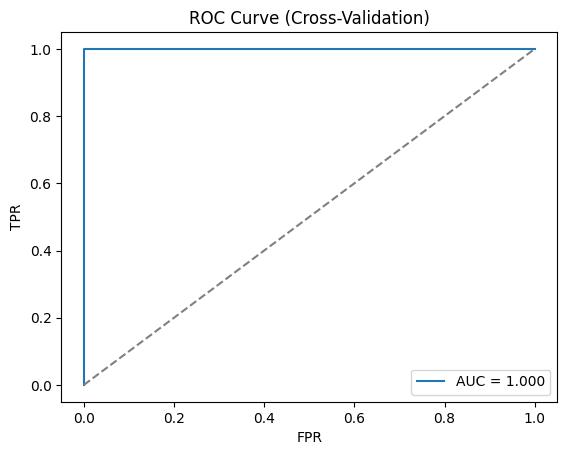

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params: {'clf__C': 0.01}
Best CV F1: 1.0


In [ ]:
# # ========================
# # 1️⃣ Import Library
# # ========================
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler
# from sklearn.impute import SimpleImputer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
# import matplotlib.pyplot as plt

# # ========================
# # 2️⃣ Load Data
# # ========================
# df = pd.read_csv("../P4/processed_kelulusan.csv")
# X = df.drop("Lulus", axis=1)
# y = df["Lulus"]

# # ========================
# # 3️⃣ Cek distribusi data
# # ========================
# print("Distribusi kelas:")
# print(y.value_counts())

# # Hitung jumlah minimal per kelas untuk menentukan jumlah fold yang aman
# min_count = int(y.value_counts().min())
# n_splits = min(5, min_count) if min_count >= 2 else 2
# print(f"\nJumlah fold (n_splits): {n_splits}")

# # ========================
# # 4️⃣ Pipeline preprocessing + model
# # ========================
# num_cols = X.select_dtypes(include="number").columns

# preprocessor = ColumnTransformer([
#     ("num", Pipeline([
#         ("imputer", SimpleImputer(strategy="median")),
#         ("scaler", StandardScaler())
#     ]), num_cols)
# ], remainder="drop")

# pipe = Pipeline([
#     ("preprocessor", preprocessor),
#     ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
# ])

# # ========================
# # 5️⃣ Cross Validation Evaluation
# # ========================
# cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Hitung skor F1 rata-rata
# scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1_macro", n_jobs=-1)
# print("\nF1_macro (mean ± std): {:.3f} ± {:.3f}".format(scores.mean(), scores.std()))
# print("Skor tiap fold:", scores)

# # ========================
# # 6️⃣ Prediksi out-of-fold untuk analisis mendalam
# # ========================
# y_pred_oof = cross_val_predict(pipe, X, y, cv=cv, method="predict", n_jobs=-1)

# print("\nClassification Report (OOF):")
# print(classification_report(y, y_pred_oof, digits=3))

# print("Confusion Matrix (OOF):")
# print(confusion_matrix(y, y_pred_oof))

# # ========================
# # 7️⃣ ROC Curve dan AUC (out-of-fold)
# # ========================
# try:
#     y_proba_oof = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
#     auc = roc_auc_score(y, y_proba_oof)
#     print("ROC-AUC (OOF): {:.3f}".format(auc))
    
#     fpr, tpr, _ = roc_curve(y, y_proba_oof)
#     plt.figure()
#     plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
#     plt.plot([0, 1], [0, 1], "--", color="gray")
#     plt.xlabel("FPR")
#     plt.ylabel("TPR")
#     plt.title("ROC Curve (Cross-Validation)")
#     plt.legend()
#     plt.show()
# except Exception as e:
#     print("ROC-AUC tidak dapat dihitung:", e)

# # ========================
# # 8️⃣ (Opsional) Hyperparameter Tuning
# # ========================
# param_grid = {
#     "clf__C": [0.01, 0.1, 1, 10],
# }
# gs = GridSearchCV(pipe, param_grid, cv=cv, scoring="f1_macro", n_jobs=-1, verbose=1)
# gs.fit(X, y)
# print("Best params:", gs.best_params_)
# print("Best CV F1:", gs.best_score_)

